<a href="https://colab.research.google.com/github/pranay-009/GAN/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as num
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import tensorflow as tf
import os

In [ ]:
from keras.datasets import cifar10

In [ ]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [ ]:
p=0
for i in range(3):
  print(p)
  print(x_train[p:p+32].shape)
  p=p+32

0
(32, 32, 32, 3)
32
(32, 32, 32, 3)
64
(32, 32, 32, 3)


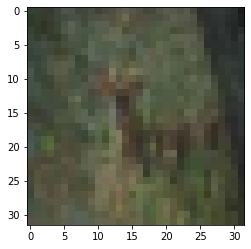

In [ ]:
plt.imshow(x_train[10])

In [ ]:
img_shape=(32,32,3)

In [ ]:
def build_generator(latent_dims,n_classes=10):
  in_label=Input(shape=(1,))
  li=Embedding(n_classes,50)(in_label)
  n_nodes=1*8*8
  li=Dense(n_nodes)(li)
  li=Reshape((8,8,1))(li)
  in_lat=Input(shape=(latent_dims,))
  n_nodes=128*8*8
  gen=Dense(n_nodes)(in_lat)
  gen=LeakyReLU(alpha=0.2)(gen)
  gen=Reshape((8,8,128))(gen)
  merge=Concatenate()([gen,li])
  gen=Conv2DTranspose(128,(4,4),padding="same",strides=(2,2))(merge)
  gen=LeakyReLU(alpha=0.2)(gen)
  gen=Conv2DTranspose(128,(4,4),padding="same",strides=(2,2))(gen)
  gen=LeakyReLU(alpha=0.2)(gen)
  out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
  return Model([in_lat,in_label],out_layer)





In [ ]:
gen=build_generator(100,10)

In [ ]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 8192)         827392      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

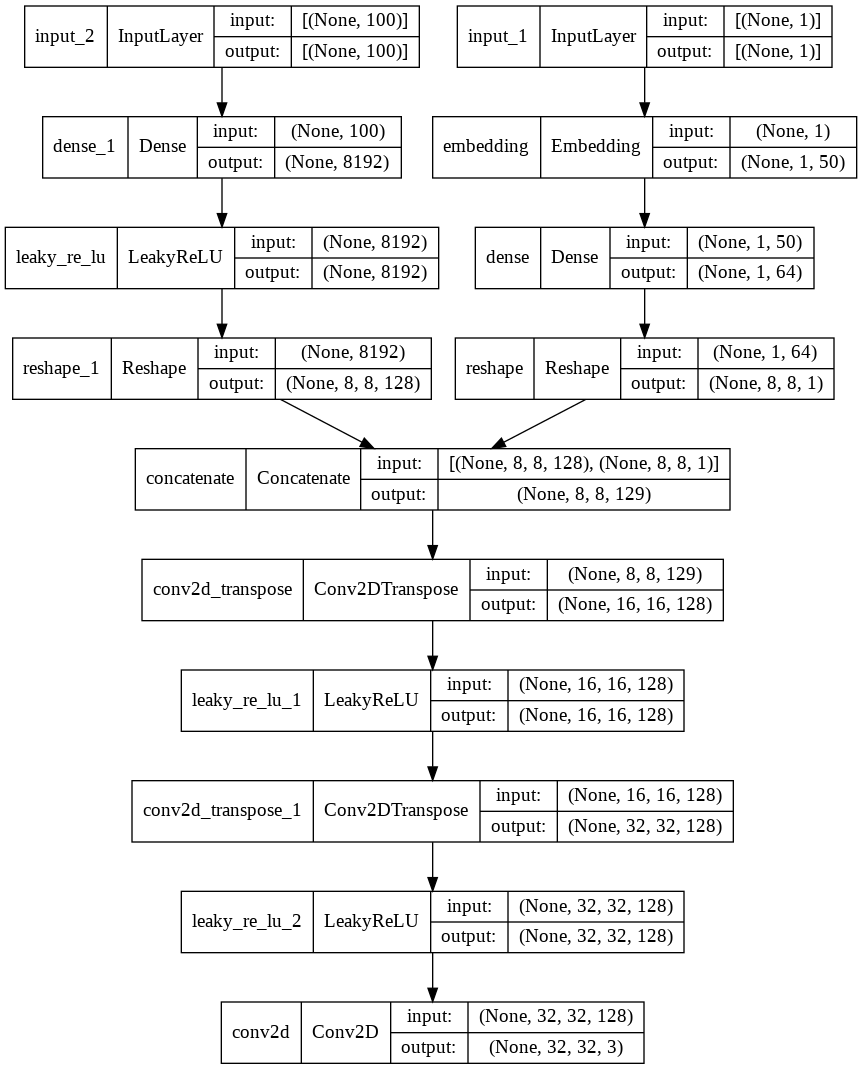

In [ ]:
tf.keras.utils.plot_model(gen,show_shapes=True)

In [ ]:
def build_discriminator():
    in_img=Input(shape=img_shape)
    in_labels=Input(shape=(1,))
    n_node=32*32
    d1=Dense(n_node)(in_labels)
    d1=Reshape((32,32,1))(d1)
    merge=Concatenate()([in_img,d1])
    fe =Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe =LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)     
    fe = Flatten()(fe)  #8192  (8*8*128=8192)

    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe) 
    return Model([in_img,in_labels],out_layer)


In [ ]:
dis=build_discriminator()

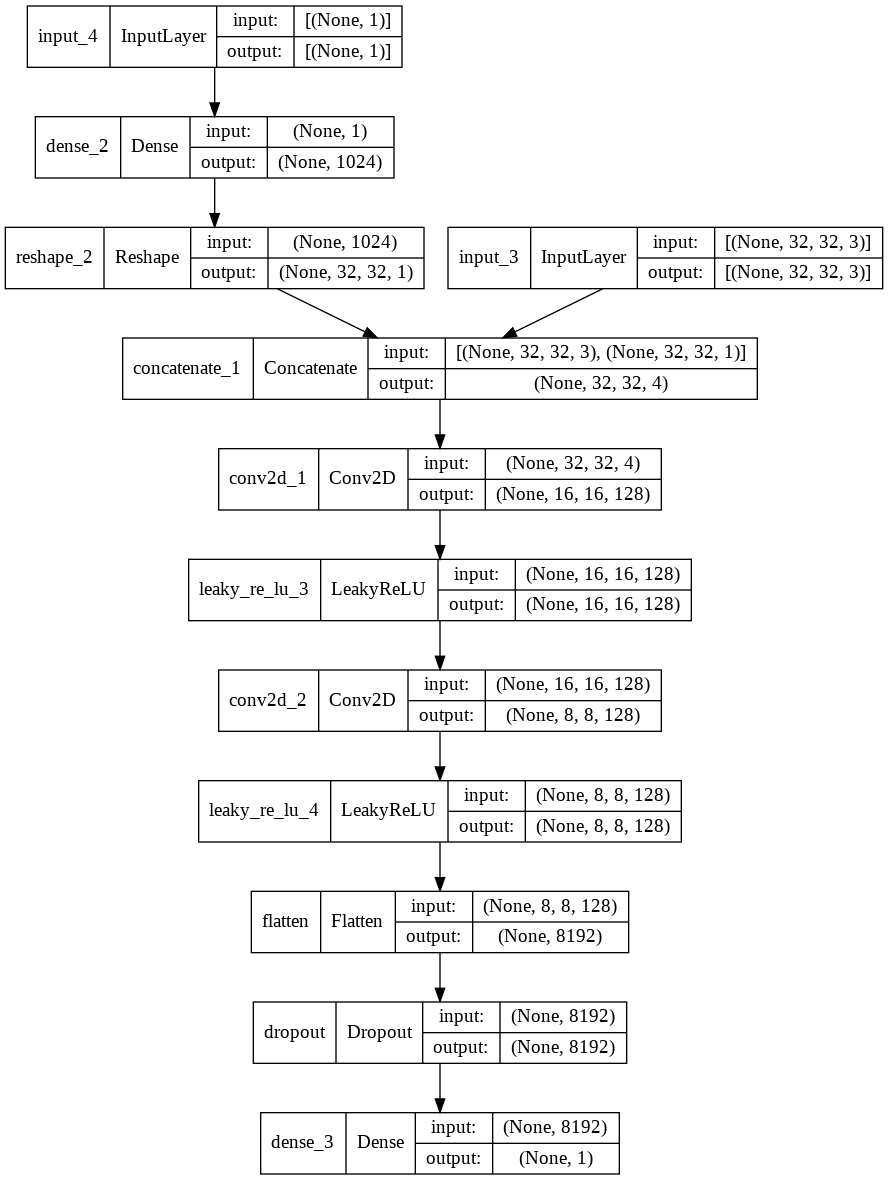

In [ ]:
tf.keras.utils.plot_model(dis,show_shapes=True)

In [ ]:
def gan_model(gen,dis):
  dis.trainable=False
  z1=Input((100,))
  l2=Input((1,))
  gan_out=gen([z1,l2])
  out=dis([gan_out,l2])
  model=Model([z1,l2],out)
  model.compile(optimizer="adam",loss="binary_crossentropy")
  return model


In [ ]:
gen(gen.input,gen.output)

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'model')>

In [ ]:
gen.output

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d')>

In [ ]:
dis.input

[<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_4')>]

In [ ]:
model=gan_model(gen,dis)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 32, 32, 3)    1382327     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            162561      ['model[1][0]',            

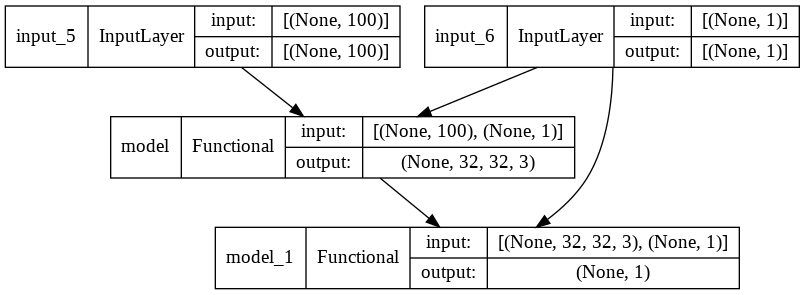

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def train(x_train,y_train,epochs,batch_size,gen,dis,model):
  x_train=(x_train.astype("float32")-127.5)/127.5
  half_batch=int(batch_size/2)
  batch_step=int(x_train.shape[0]/batch_size)

  for epoch in range(epochs):
    s=0

    for batch in range(batch_step):
        gen_in=num.random.normal(0,1,(half_batch,100))
        gen_label=num.random.randint(0,10,(half_batch,1))
        with tf.device('/device:GPU:0'):
          fake_out=gen.predict([gen_in,gen_label])
          x=x_train[s:(s+half_batch)]
          y=y_train[s:(s+half_batch)]

          dis_real_loss=dis.train_on_batch([x,y],num.ones((half_batch,1)))
          dis_fake_loss=dis.train_on_batch([fake_out,gen_label],num.zeros((half_batch,1)))
          s=s+batch_size

          dis_loss=0.5*(num.add(dis_real_loss,dis_fake_loss))

          latency=num.random.normal(0,1,(batch_size,100))
          label=num.random.randint(0,10,(batch_size,1))
          fake_out=num.ones((batch_size,1))
          gan_loss=model.train_on_batch([latency,label],fake_out)
          

        if (batch==(batch_step-1)):
          print ("epoch :%d   batch size: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,batch_step, dis_loss[0], 100*dis_loss[1], gan_loss))

In [ ]:
#num.random.normal(0,1,(64,100)).shape

In [ ]:
#num.random.randint(0,10,(64,1))

In [ ]:
num.ones((64,1)).shape


(64, 1)

In [ ]:
gen.compile(optimizer="adam",loss="binary_crossentropy")


In [ ]:
dis.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy")

In [ ]:
train(x_train,y_train,100,32,gen,dis,model)

epoch :0   batch size: 1562 [D loss: 3.070084, acc.: 40.62%] [G loss: 0.004419]
epoch :1   batch size: 1562 [D loss: 3.081516, acc.: 37.50%] [G loss: 0.003943]
epoch :2   batch size: 1562 [D loss: 3.103462, acc.: 40.62%] [G loss: 0.003877]
epoch :3   batch size: 1562 [D loss: 3.119048, acc.: 40.62%] [G loss: 0.003778]
epoch :4   batch size: 1562 [D loss: 3.143286, acc.: 43.75%] [G loss: 0.003869]
epoch :5   batch size: 1562 [D loss: 3.132455, acc.: 50.00%] [G loss: 0.003767]
epoch :6   batch size: 1562 [D loss: 3.149276, acc.: 37.50%] [G loss: 0.003744]
epoch :7   batch size: 1562 [D loss: 3.144118, acc.: 40.62%] [G loss: 0.003671]
epoch :8   batch size: 1562 [D loss: 3.141949, acc.: 40.62%] [G loss: 0.003622]
epoch :9   batch size: 1562 [D loss: 3.152774, acc.: 43.75%] [G loss: 0.003629]
epoch :10   batch size: 1562 [D loss: 3.144076, acc.: 46.88%] [G loss: 0.003583]
epoch :11   batch size: 1562 [D loss: 3.133611, acc.: 43.75%] [G loss: 0.003626]
epoch :12   batch size: 1562 [D loss: 

In [ ]:
test_sample=num.random.normal(0,1,(4,100))
test_sample_label=num.array([[1],[2],[3],[4]])

In [ ]:
test_sample_label.shape

(4, 1)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
pred=gen.predict([test_sample,test_sample_label])

In [ ]:
pred.shape

(4, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


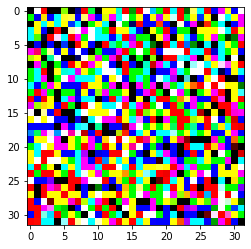

In [ ]:
plt.imshow(pred[1])

In [ ]:
tf.device

<function tensorflow.python.framework.ops.device_v2>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.982170997999674
GPU (s):
0.043855411000095046
GPU speedup over CPU: 68x
